In [1]:

import numpy as np
import pandas as pd 
import re
from nltk.corpus import stopwords 
from nltk.stem.porter import PorterStemmer #reduces word to root word
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score


In [2]:
import nltk 
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
df = pd.read_csv("/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv", encoding='ISO-8859-1')
df.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [4]:
df.shape

(1599999, 6)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599999 entries, 0 to 1599998
Data columns (total 6 columns):
 #   Column                                                                                                               Non-Null Count    Dtype 
---  ------                                                                                                               --------------    ----- 
 0   0                                                                                                                    1599999 non-null  int64 
 1   1467810369                                                                                                           1599999 non-null  int64 
 2   Mon Apr 06 22:19:45 PDT 2009                                                                                         1599999 non-null  object
 3   NO_QUERY                                                                                                             1599999 non-null  object
 4   _

# naming coloumns

In [6]:
coloumns=["target","id","date","flag","user","text"]
twitter_data = pd.read_csv("/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv",names=coloumns, encoding='ISO-8859-1')
twitter_data.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [7]:
twitter_data.isnull().sum()

target    0
id        0
date      0
flag      0
user      0
text      0
dtype: int64

# distribution of target coloumn in data

In [8]:
twitter_data.target.value_counts()


target
0    800000
4    800000
Name: count, dtype: int64

### perfect distribution

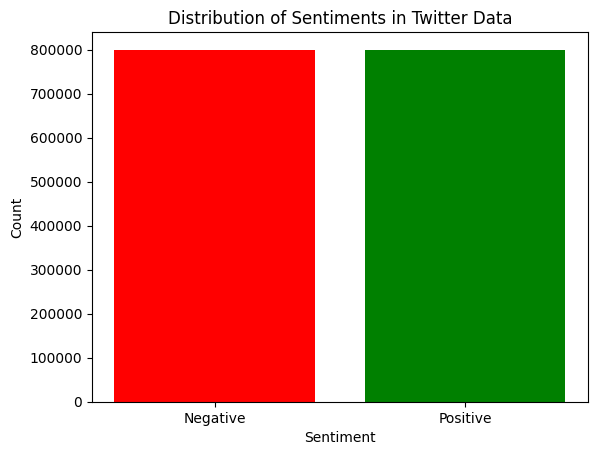

In [9]:
import matplotlib.pyplot as plt

# Calculate sentiment counts from the DataFrame
sentiment_counts = twitter_data['target'].value_counts()

# Plot
plt.bar(['Negative', 'Positive'], sentiment_counts.values, color=['red', 'green'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Distribution of Sentiments in Twitter Data')
plt.show()


In [10]:

twitter_data.replace({'target': {4: 1}}, inplace=True)


In [11]:
twitter_data.target.value_counts()

target
0    800000
1    800000
Name: count, dtype: int64

# now we need to clean the text data remove stop words

In [12]:
portstem=PorterStemmer()

In [15]:
def clean(content):
    cleaned_content = re.sub("[^a-zA-Z]", " ", content)  # Replace non-alphabetic characters with space
    cleaned_content = cleaned_content.lower()  # Convert to lowercase
    cleaned_content = cleaned_content.split()  # Split the text into words
    stowords = set(stopwords.words('english'))  # Get English stopwords
    cleaned_content = [portstem.stem(word) for word in cleaned_content if word not in stowords] 
    cleaned_content=" ".join(cleaned_content)
    return cleaned_content  

In [16]:
twitter_data['cleaned_data']=twitter_data['text'].apply(clean)
twitter_data

,target,id,date,flag,user,text,cleaned_data
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot http twitpic com zl awww bummer sho...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset updat facebook text might cri result sch...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,kenichan dive mani time ball manag save rest g...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole bodi feel itchi like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass behav mad see
...,...,...,...,...,...,...,...
1599995,1,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...,woke school best feel ever
1599996,1,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...,thewdb com cool hear old walt interview http b...
1599997,1,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...,readi mojo makeov ask detail
1599998,1,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...,happi th birthday boo alll time tupac amaru sh...


In [17]:
X=twitter_data['cleaned_data'].values
Y=twitter_data["target"].values

In [18]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,stratify=Y,random_state=153)

In [19]:
print(X_train)

['ahh rememb old day taylorswift one twitter' 'good morn everybodi'
 'dinner danc awesom good job everyon award night offici graduat today miss class'
 ... 'kimberleyxlynn guess got decent weather rain'
 'total deck fashion scarf v neck go hit store'
 'great wednesday night fantast lost final fave idol contest made final']


In [20]:
Y_train.shape

(1280000,)

# x is still a text we need to change to numerical 

In [21]:
vectorizer=TfidfVectorizer()
X_train=vectorizer.fit_transform(X_train)
X_test= vectorizer.transform(X_test)

  (0, 376465)	0.41724464908348224
  (0, 363147)	0.4114951531419261
  (0, 333437)	0.3351776230564357
  (0, 318560)	0.4416396431542913
  (0, 264822)	0.27791667894236666
  (0, 228111)	0.27523647007841484
  (0, 35574)	0.4429404400741844


In [22]:
print(X_test)

  (0, 376465)	0.41724464908348224
  (0, 363147)	0.4114951531419261
  (0, 333437)	0.3351776230564357
  (0, 318560)	0.4416396431542913
  (0, 264822)	0.27791667894236666
  (0, 228111)	0.27523647007841484
  (0, 35574)	0.4429404400741844
  (1, 169595)	0.7258362974701646
  (1, 159450)	0.345361515770165
  (1, 124602)	0.37789867513602476
  (1, 54906)	0.4594340910622263
  (2, 400727)	0.18259634410047307
  (2, 376455)	0.23311267057074167
  (2, 279151)	0.20250896929880888
  (2, 250289)	0.24330926086316582
  (2, 234703)	0.16897546845081754
  (2, 169454)	0.1940954138592238
  (2, 156225)	0.22921274818173223
  (2, 148524)	0.2548816802019471
  (2, 91062)	0.3690115515013257
  (2, 89622)	0.36648500322125915
  (2, 78773)	0.4007934868141203
  (2, 31102)	0.18453882061871385
  (2, 15136)	0.4039902316960868
  (3, 412831)	0.3188495625605144
  :	:
  (319997, 296671)	0.46764996669257575
  (319997, 166005)	0.3784484568935168
  (319997, 158828)	0.4941027799949181
  (319997, 150709)	0.1454542807699016
  (319997, 1

In [23]:
model=LogisticRegression(max_iter=2000)

In [24]:
model.fit(X_train,Y_train)

LogisticRegression(max_iter=2000)

In [25]:
Y_train_pred=model.predict(X_train)
accuracy=accuracy_score(Y_train,Y_train_pred)
print(accuracy)

0.81018515625


In [26]:
import pickle
pickle.dump(model,open("twitter_model","wb"))

In [27]:
with open("twitter_model", "rb") as file:
    loaded_model = pickle.load(file)

In [28]:
# Predict the sentiment for the transformed tweets using the loaded model
predicted_sentiments = loaded_model.predict(X_test)

# Print the predicted sentiments
print("Predicted Sentiments:", predicted_sentiments)


Predicted Sentiments: [1 1 1 ... 0 0 1]


In [32]:
print(X_test[0])

  (0, 376465)	0.41724464908348224
  (0, 363147)	0.4114951531419261
  (0, 333437)	0.3351776230564357
  (0, 318560)	0.4416396431542913
  (0, 264822)	0.27791667894236666
  (0, 228111)	0.27523647007841484
  (0, 35574)	0.4429404400741844


In [43]:
def tweetsentiment(tweet):
    cleaned_tweet = clean(tweet)
    tweet_vectorized = vectorizer.transform([cleaned_tweet])
    predicted_sentiment = loaded_model.predict(tweet_vectorized)
    if predicted_sentiment==1:
         print("Predicted Sentiment for the New Tweet is positive")
    else:
         print("Predicted Sentiment for the New Tweet is negative")
   
    

In [47]:
# Define the tweets as Python variables in an array
tweets = [
    "I love spending time with my friends. It always makes me happy!",
    "Today was a terrible day. Everything went wrong.",
    "The food at the new restaurant was amazing. I can't wait to go back!",
    "Feeling sick and tired. I just want to stay in bed all day.",
    "Received a promotion at work! Hard work pays off.",
    "I can't believe how rude some people can be. It ruins my mood.",
    "Spent the day at the beach with my family. It was so much fun!",
    "Stuck in traffic again. This day couldn't get any worse.",
    "Got accepted into my dream university! Excited for the future.",
    "Feeling lonely and sad. Wish I had someone to talk to."
]

# Loop through the array of tweets and call the tweetsentiment(tweet) function
for tweet in tweets:
    print(tweet)
    sentiment = tweetsentiment(tweet)
    print()


I love spending time with my friends. It always makes me happy!
Predicted Sentiment for the New Tweet is positive

Today was a terrible day. Everything went wrong.
Predicted Sentiment for the New Tweet is negative

The food at the new restaurant was amazing. I can't wait to go back!
Predicted Sentiment for the New Tweet is positive

Feeling sick and tired. I just want to stay in bed all day.
Predicted Sentiment for the New Tweet is negative

Received a promotion at work! Hard work pays off.
Predicted Sentiment for the New Tweet is negative

I can't believe how rude some people can be. It ruins my mood.
Predicted Sentiment for the New Tweet is negative

Spent the day at the beach with my family. It was so much fun!
Predicted Sentiment for the New Tweet is positive

Stuck in traffic again. This day couldn't get any worse.
Predicted Sentiment for the New Tweet is negative

Got accepted into my dream university! Excited for the future.
Predicted Sentiment for the New Tweet is positive

Fee

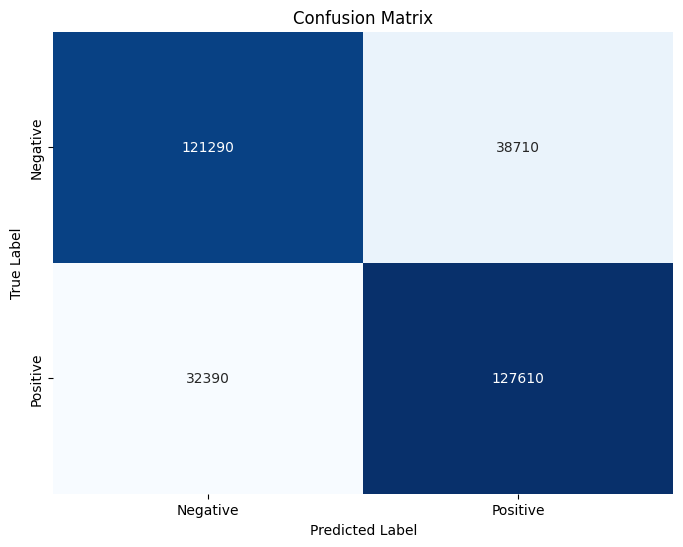

In [48]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred = model.predict(X_test)
cm = confusion_matrix(Y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()
